In [1]:
import pandas as pd
import numpy as np
import cooler
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Patch
import scipy.io
import pysam


from sklearn.decomposition import PCA
from scipy import stats
import networkx as nx
from sklearn.metrics import jaccard_score

import os
import sys
from importlib import reload

import filters
import pore_c_utils as pcu
import binning_utils as binning
import plotting as hicPlot

In [2]:
filepath = "filtered_data/clique1MBfiltered.csv"

df = pd.read_csv(filepath)
print(f"{df.shape=}")
df.head()

/sw/arcts/centos7/python3.8-anaconda/2020.07/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (39) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


df.shape=(636130, 65)


,index,read_name,read_length,read_idx,contact_is_direct,contact_is_cis,contact_read_distance,contact_genome_distance,contact_fragment_adjacent,contact_fragment_distance,...,align1_absolute_midpoint,align2_absolute_midpoint,mean_mapping_quality,contact_count,align1_fragcount,align2_fragcount,align1_n_reads,align2_n_reads,contact_has_support,cell
0,27771,132f1be4-df3c-4a1f-bc53-40df856b0c42,4312,35703,False,True,1619,11803,False,12375,...,2630943949,2630956324,50.0,1,4,3,NaN,NaN,1,run01
1,206517,b0e13742-1d17-47d9-a017-668f37b6788f,2616,7786,False,True,1432,714701,False,715354,...,2630229012,2630944366,96.0,1,4,2,NaN,NaN,1,run01
2,117363,330b862a-138c-48d7-9534-be879100a320,1022,31146,True,True,1,1378,False,1844,...,2630227938,2630229781,49.5,1,3,2,NaN,NaN,1,run01
3,468866,af44682d-de48-467d-8cd2-f79d45b85f69,1364,36416,True,True,254,729058,False,729603,...,2630227390,2630956993,47.5,1,2,3,NaN,NaN,1,run01
4,180875,7470a373-22cb-49b2-a0df-9e5279d9559c,3386,7678,False,True,866,716159,False,716559,...,2630227390,2630943949,50.5,1,2,4,NaN,NaN,1,run01


In [3]:
dfList = []

for runId in df['cell'].unique():
    filepath = f'filtered_data/{runId}_sequences.csv'
    cellDf = pd.read_csv(filepath)
    dfList.append(cellDf)

seqs = pd.concat(dfList, ignore_index=True)
print(f"{seqs.shape=}")
seqs.head()

seqs.shape=(1586663, 9)


,read_name,read_idx,align_idx,seq,read_length,read_start,read_end,file,runId
0,3093bc64-a1fe-47fc-868e-57ca8413f1aa,20692,102390,AGTACTTCAGTTTAGTTACAGCTTATTCTTCAGGTTAAAAGGTTAC...,7606.0,2498,4518,NlaIII_run01_batch20_GRCm39.coord_sort.bam,run01
1,3093bc64-a1fe-47fc-868e-57ca8413f1aa,20692,102396,TCTGACTGTGGCCTTAGAGCAGGTGATGGAAGGGCTGAAGGTAGGT...,7606.0,7182,7520,NlaIII_run01_batch20_GRCm39.coord_sort.bam,run01
2,3093bc64-a1fe-47fc-868e-57ca8413f1aa,20692,102394,TCTGACTGTGGCCTTAGAGCAGGTGATGGAAGGGCTGAAGGTAGGT...,7606.0,5104,5875,NlaIII_run01_batch20_GRCm39.coord_sort.bam,run01
3,3093bc64-a1fe-47fc-868e-57ca8413f1aa,20692,102392,AGTACTTCAGTTTAGTTACAGCTTATTCTTCAGGTTAAAAGGTTAC...,7606.0,420,1266,NlaIII_run01_batch20_GRCm39.coord_sort.bam,run01
4,3093bc64-a1fe-47fc-868e-57ca8413f1aa,20692,102393,TCTGACTGTGGCCTTAGAGCAGGTGATGGAAGGGCTGAAGGTAGGT...,7606.0,5261,6045,NlaIII_run01_batch20_GRCm39.coord_sort.bam,run01


In [4]:
adjacentContact = df[df['contact_is_direct'] == True]
print(f"{adjacentContact.shape=}")

adjacentContact.shape=(219722, 65)


In [5]:
adjacentContact.columns

Index(['index', 'read_name', 'read_length', 'read_idx', 'contact_is_direct',
       'contact_is_cis', 'contact_read_distance', 'contact_genome_distance',
       'contact_fragment_adjacent', 'contact_fragment_distance',
       'haplotype_pair_type', 'align1_align_idx', 'align1_chrom',
       'align1_start', 'align1_end', 'align1_strand', 'align1_mapping_quality',
       'align1_align_score', 'align1_align_base_qscore', 'align1_phase_set',
       'align1_phase_qual', 'align1_haplotype', 'align1_fragment_id',
       'align1_fragment_start', 'align1_fragment_end', 'align2_align_idx',
       'align2_chrom', 'align2_start', 'align2_end', 'align2_strand',
       'align2_mapping_quality', 'align2_align_score',
       'align2_align_base_qscore', 'align2_phase_set', 'align2_haplotype',
       'align2_fragment_id', 'align2_fragment_start', 'align2_fragment_end',
       'batch_id', 'align1_chromosome_name', 'align1_chrom_length',
       'align1_genbank', 'align1_refSeq', 'align1_chrom_end',
      

In [6]:
# break

In [7]:
cell = 'run05'
chrom = '2'

subset = adjacentContact[adjacentContact['cell'] == cell]
subset = subset[(subset['align1_chromosome_name'] == chrom) & (subset['align2_chromosome_name'] == chrom)]
print(f"{subset.shape=}")

subset.shape=(932, 65)


In [8]:
cutter = 'CATG'
buffer = 50 # bp ON EITHER SIDE OF THE FRAGMENT

def getSequencePosition(seqs, read_name, align_idx):
    """A function to return the str sequence given a read name and alignment index
    """
    query = (seqs['read_name'] == read_name) & (seqs['align_idx'] == align_idx)
    res = seqs.loc[query]
    
    start = res['read_start'].values[0]
    end = res['read_end'].values[0]
    seq = res['seq'].values[0]

    return seq, start, end 
    

cutCounts = []
noMansLands = []
fullSequence = []


for idx, row in subset.iterrows():
    
    count += 1
    
    read_name = row['read_name']
    unMappedLen = row['contact_read_distance']
    
    align_idx = row['align1_align_idx']
    seq, start, end = getSequencePosition(seqs, read_name, align_idx)
    
    indicator = 0
    
    if unMappedLen >= 0:
        seqStart = end - buffer
        seqEnd = end + unMappedLen + buffer
        noMansLand = seq[seqStart: seqEnd]
    else:
        indicator = 1
        seqStart = (end + unMappedLen) - buffer
        seqEnd = end + buffer
        noMansLand = seq[seqStart: seqEnd]
    
    cutSites = noMansLand.count(cutter)
    noMansLands.append(noMansLand)
    fullSequence.append(seq)
    
    cutCounts.append(cutSites)
    

subset['seqs'] = fullSequence
subset['noMansLand'] = noMansLands
    
subset['cutCounts'] = cutCounts
print(f"{np.mean(cutCounts)=}")
print(f"{np.min(cutCounts)=}")
print(f"{np.max(cutCounts)=}")

print('done.')

np.mean(cutCounts)=1.0268240343347639
np.min(cutCounts)=0
np.max(cutCounts)=9
done.


In [18]:
noCuts = subset[subset['cutCounts'] == 0]
print(f"{noCuts.shape=}")

noCuts.shape=(327, 69)


In [24]:
subset['hasCut'] = np.where(subset['cutCounts'] > 0, 1, 0)
postiveDist = subset[subset['contact_read_distance'] > 5]
postiveDist['hasCut'].value_counts(normalize=True)

1    0.737463
0    0.262537
Name: hasCut, dtype: float64

In [17]:
# plt.rcParams['figure.dpi'] = 150
# plt.rcParams['figure.figsize'] = 6, 4
# plt.hist(subset['contact_read_distance'], edgecolor='k')
# plt.title('Read Distance Between Adjacent Loci')
# plt.xlabel('Distance (bp)')
# plt.ylabel('Count of Pairs')

In [19]:
cutCountsSecondary = []

count = 0

for idx, row in noCuts.iterrows():
    align_idx = row['align2_align_idx']
    read_name = row['read_name']
    seq, start, end = getSequencePosition(seqs, read_name, align_idx)
    
    if unMappedLen >= 0:
        seqStart = start - unMappedLen - buffer
        seqEnd = start + buffer
        noMansLand = seq[seqStart: seqEnd]
    else:
        seqStart = start - buffer
        seqEnd = start + unMappedLen + buffer
        noMansLand = seq[seqStart: seqEnd]
        
    cutSites = noMansLand.count(cutter)
    
    if cutSites < 1:
        count += 1
        
        
print(count)

198


np.min(subset['noMansLen'])=50
np.max(subset['noMansLen'])=1100


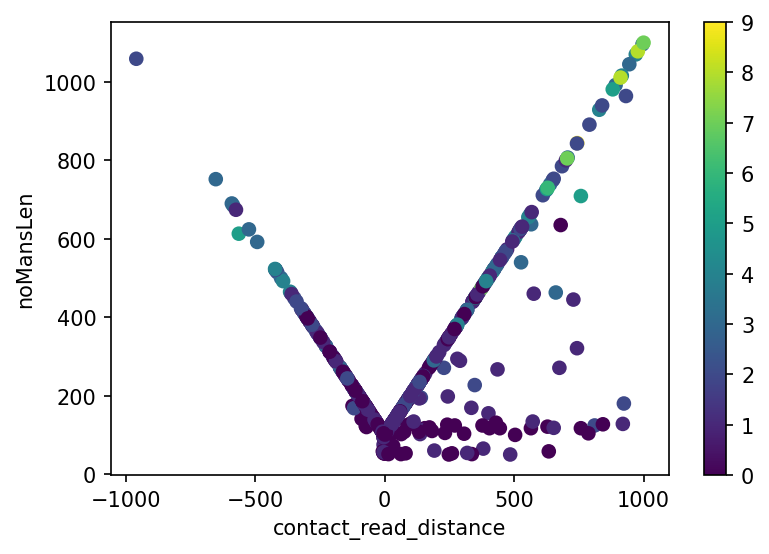

In [16]:
# subset['noMansLen'] = subset['noMansLand'].apply(len)
# print(f"{np.min(subset['noMansLen'])=}")
# print(f"{np.max(subset['noMansLen'])=}")

# plt.scatter(subset['contact_read_distance'], 
#             subset['noMansLen'],
#             c=subset['cutCounts'])

# plt.xlabel('contact_read_distance')
# plt.ylabel('noMansLen')
# plt.colorbar()